# Bringing Better Healthcare to Developing Countries
### Problem Statement 3 - Achieving <b>GOOD HEALTH & WELL-BEING</b> in the World!
--------
### Using Reinforcement Learning (RL) to optimize Dynamic Treatment Regimes (DTRs) for HIV patients in developing countries

By Baby Boss (Xiaoxuan, Voan, Enoch, Rui Bin, Leo)

Dataset can be found [here](https://figshare.com/articles/dataset/The_Health_Gym_v2_0_Synthetic_Antiretroviral_Therapy_ART_for_HIV_Dataset/22827878).

--------

<br>

| Title | Category | Meaning | Comments |
| ----- | -------- | ------- | ------- |
| VL | Patient's Health Status | Viral Load (copies/mL)  |
| CD4 | Patient's Health Status | Absolute Count for CD4 (cells/uL) |
| Rel CD4 | Patient's Health Status | Relative Count for CD4 (cells/uL) |
| Base Drug Combo | HIV Treatments | FTC + TDF <br> 3TC + ABC <br> FTC + TAF <br> DRV + FTC + TDF <br> FTC + RTVB + TDF <br> Other | Class 0 = FTC + TDF<br>Class 1 = 3TC + ABC<br>Class 2 = DRV + FTC + TDF<br>Class 3 = Other<br>Class 4 = FTC + RTVB + TDF<br>Class 5 = FTC + TAF |
| Comp. INI | HIV Treatments | Complimentary INI (Integrase Inhibitor) | Class 0 = Not Applied<br>Class 1 = DTG<br>Class 2 = EVG<br>Class 3 = DTG |
| Comp. NNRTI | HIV Treatments | Complimentary NNRTI (Nucleotide Reverse Transcriptase Inhibitors)| Class 0 = Not Applied<br>Class 1 = RPV<br>Class 2 = EFV<br>Class 3 = NVP |
| Extra PI | HIV Treatments | Extra Protease Inhibitors | Class 0 = Not Applied<br>Class 1 = ATV<br>Class 2 = RTVB<br>Class 3 = RTV<br>Class 4 = LPV<br>Class 5 = DRV |
| Extra pk-En | HIV Treatments | Extra pk-Enhancer | Class 0 = False<br>Class 1 = True |	
| VL (M) | Binary Measurement | VL Measured | Class 0 = False<br>Class 1 = True |	
| CD4 (M) | Binary Measurement | CD4 Measured | Class 0 = False<br>Class 1 = True |	
| Drug (M) | Binary Measurement | Drug Measured | Class 0 = False<br>Class 1 = True |	
| PatientID | Patient's Identifier | Patient Identification Number | Range between 0 to 8915 |
| Timestep | Patient's Identifier | Patient's Visit Sorted by Time | Range between 0 to 59 |
| Gender | Patient's Identifier | Male<br>Female | Class 0 = Male<br>Class 1 = Female |
| Ethnic (Ethnicity) | Patient's Identifier | Asian<br>African<br>Caucasian<br>Other | Class 0 = Asian<br>Class 1 = Afro<br>Class 2 = Caucasian<br>Class 3 = Other |


<br>

---------

In [ ]:
# Install the required packages
%pip install pandas gym matplotlib numpy

In [ ]:
import pandas as pd
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load dataset

original_data = pd.read_csv('HIV_dataset.csv')
original_data

,VL,CD4,Rel CD4,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL (M),CD4 (M),Drug (M),PatientID,Timestep
0,29.944271,793.45830,30.834505,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,1.0,1.0,0,0
1,29.241980,467.41890,30.355980,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,1
2,28.748991,465.12485,30.405320,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,2
3,28.101835,692.00690,30.248816,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,3
4,28.813837,641.75714,29.944712,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534955,8.633752,4061.17580,38.708908,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,55
534956,112.354550,2626.29880,22.839344,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,56
534957,9.187279,3726.58370,37.175346,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,57
534958,18.690529,2740.06540,29.395905,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,58


In [ ]:
# Preprocessing Data

def preprocess_data(dataframe):
    
    # To index from 0
    dataframe['Gender'] -= 1
    dataframe['Ethnic'] -= 1
    
    # Identify the columns to be shifted to the end
    columns_to_shift_start = ['PatientID', 'Timestep', 'Gender', 'Ethnic']
    columns_to_shift_end = ['VL', 'CD4', 'Rel CD4']

    # Create a list of columns excluding the ones to be shifted, and put the shifted columns at the end
    other_columns = [col for col in dataframe.columns if col not in columns_to_shift_start and col not in columns_to_shift_end]
    new_order = columns_to_shift_start + other_columns + columns_to_shift_end
    data_reordered = dataframe[new_order]
    
    return data_reordered

data = preprocess_data(original_data)
data

,PatientID,Timestep,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL (M),CD4 (M),Drug (M),VL,CD4,Rel CD4
0,0,0,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0.0,1.0,1.0,29.944271,793.45830,30.834505
1,0,1,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,29.241980,467.41890,30.355980
2,0,2,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,28.748991,465.12485,30.405320
3,0,3,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,28.101835,692.00690,30.248816
4,0,4,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,28.813837,641.75714,29.944712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534955,8915,55,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8.633752,4061.17580,38.708908
534956,8915,56,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,112.354550,2626.29880,22.839344
534957,8915,57,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,9.187279,3726.58370,37.175346
534958,8915,58,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,18.690529,2740.06540,29.395905


In [ ]:
# Check data distribution

data.describe()

,PatientID,Timestep,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL (M),CD4 (M),Drug (M),VL,CD4,Rel CD4
count,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000
mean,4457.500000,29.500000,0.136945,2.486092,1.021194,2.166691,2.375819,4.180348,0.066876,0.130894,0.155215,0.776847,7041.119417,823.080891,36.352855
std,2573.829889,17.318118,0.343789,0.783357,1.311942,1.257013,0.847216,1.635013,0.249807,0.337285,0.362110,0.416361,18240.801089,1250.245010,30.404427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101498,7.962432,1.871511
25%,2228.750000,14.750000,0.000000,2.000000,0.000000,1.000000,2.000000,5.000000,0.000000,0.000000,0.000000,1.000000,10.490656,272.852865,17.461661
50%,4457.500000,29.500000,0.000000,3.000000,1.000000,3.000000,3.000000,5.000000,0.000000,0.000000,0.000000,1.000000,38.783188,466.403180,27.733725
75%,6686.250000,44.250000,0.000000,3.000000,1.000000,3.000000,3.000000,5.000000,0.000000,0.000000,0.000000,1.000000,778.271910,859.435142,44.152004
max,8915.000000,59.000000,1.000000,3.000000,5.000000,3.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,97566.414000,42475.200000,586.634600


In [ ]:
# Check for any missing values

def check_missing_values(data):
    if any(data.isna().any()):
        return "There are missing values in the dataset."
    else:
        return "There are no missing values in the dataset."

print(check_missing_values(data))

There are no missing values in the dataset.


## Data Visualization

In [110]:
class_names = {
    "Gender": {0: "Male", 1: "Female"},
    "Ethnic": {0: "Asian", 1: "Afro", 2: "Caucasian", 3: "Other"},
    "Base Drug Combo": {0: "FTC + TDF", 1: "3TC + ABC", 2: "DRV + FTC + TDF",
                        3: "Other", 4: "FTC + RTVB + TDF", 5: "FTC + TAF"},
    "Comp. INI": {0: "Not Applied", 1: "DTG", 2: "EVG", 3: "DTG"},
    "Comp. NNRTI": {0: "Not Applied", 1: "RPV", 2: "EFV", 3: "NVP"},
    "Extra PI": {0: "Not Applied", 1: "ATV", 2: "RTVB", 3: "RTV", 4: "LPV", 5: "DRV"},
    "Extra pk-En": {0: "False", 1: "True"},
    "VL (M)": {0: "False", 1: "True"},
    "CD4 (M)": {0: "False", 1: "True"},
    "Drug (M)": {0: "False", 1: "True"}
}

def visualize_data(data):
    # Create a list of columns to ignore
    ignore_col = ["VL", "CD4", "Rel CD4", "PatientID", "Timestep"]

    num_cols = len(data.columns) - len(ignore_col)
    num_rows = 2
    fig, axes = plt.subplots(num_rows, int(num_cols / num_rows), figsize=(20, 5))

    axes = axes.flatten()

    subplot_index = 0

    # Iterate over columns and plot pie charts
    for column in data.columns:
        if column in ignore_col:
            continue
        counts = data[column].value_counts()
        # Access the appropriate subplot
        ax = axes[subplot_index] if num_cols > 1 else axes
        labels = [class_names[column][label] for label in counts.index]
        ax.pie(counts, labels=labels, autopct='%1.1f%%')

        ax.set_title(column)
        subplot_index += 1

    plt.tight_layout()
    plt.show()

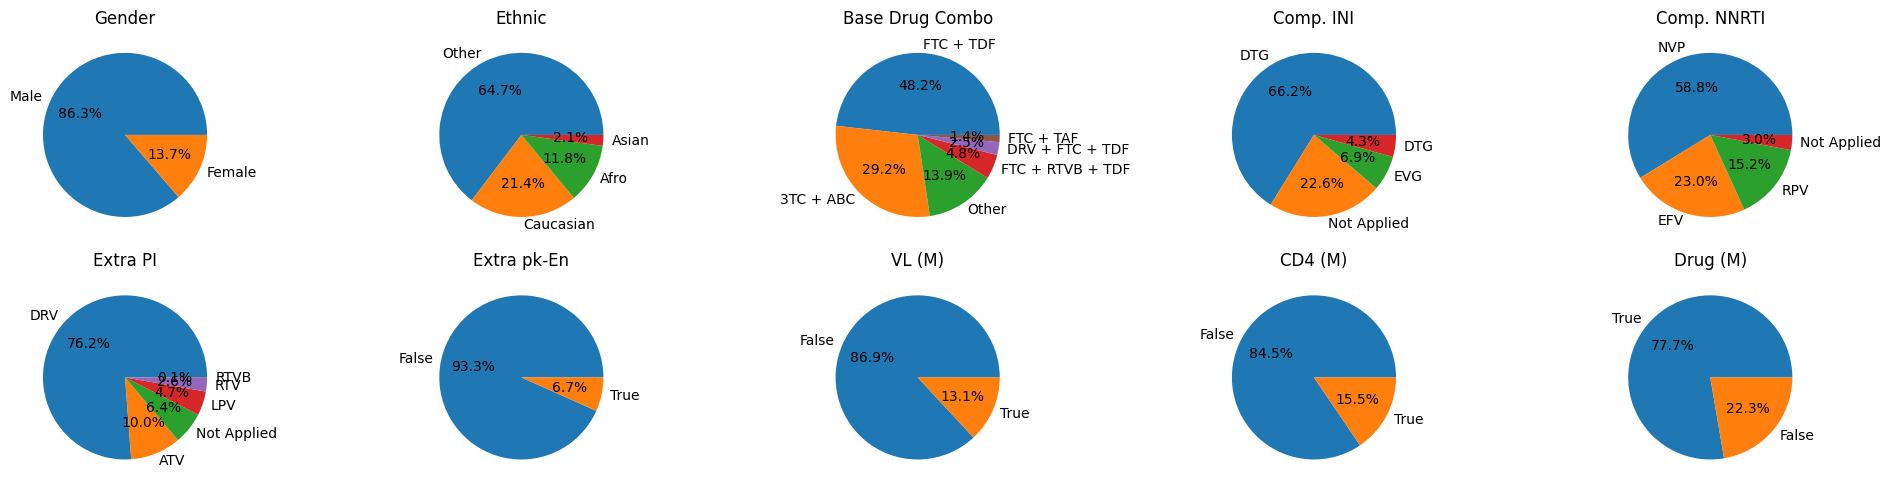

In [111]:
visualize_data(data)

In [ ]:
# Plotting Time-Series Functions

def plot_time_series(df, patient_id):
    # Filter DataFrame based on patient_id
    patient_data = df[df['PatientID'] == patient_id]


    # Plot time-series data
    plt.figure(figsize=(10, 6))
    plt.plot(patient_data['Timestep'] + 1, patient_data['VL'], label='VL')
    plt.plot(patient_data['Timestep'] + 1, patient_data['CD4'], label='CD4')
    plt.plot(patient_data['Timestep'] + 1,
             patient_data['Rel CD4'], label='Rel CD4')

    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.title(f'Time Series Data for Patient {patient_id}')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_vl(data, patient_id, color="blue"):
    # Filter DataFrame based on patient_id
    patient_data = data[data['PatientID'] == patient_id]

    # Plot VL time-series data
    plt.plot(patient_data['Timestep'], patient_data['VL'],
             label=f'Patient {patient_id}: VL', color=color)

    plt.xlabel('Timestep')
    plt.ylabel('VL Value')
    plt.title(f'VL Time Series Data for Patient {patient_id}')
    plt.grid(True)
    plt.show()


def plot_cd4(data, patient_id, color="orange"):
    # Filter DataFrame based on patient_id
    patient_data = data[data['PatientID'] == patient_id]

    # Plot CD4 time-series data
    plt.plot(patient_data['Timestep'], patient_data['CD4'],
             label=f'Patient {patient_id}: CD4', color=color)

    plt.xlabel('Timestep')
    plt.ylabel('CD4 Value')
    plt.title(f'CD4 Time Series Data for Patient {patient_id}')
    plt.grid(True)
    plt.show()


def plot_rel_cd4(data, patient_id, color="green"):
    # Filter DataFrame based on patient_id
    patient_data = data[data['PatientID'] == patient_id]

    # Plot Rel CD4 time-series data
    plt.plot(patient_data['Timestep'], patient_data['Rel CD4'],
             label=f'Patient {patient_id}: Rel CD4', color=color)

    plt.xlabel('Timestep')
    plt.ylabel('Rel CD4 Value')
    plt.title(f'Rel CD4 Time Series Data for Patient {patient_id}')
    plt.grid(True)
    plt.show()

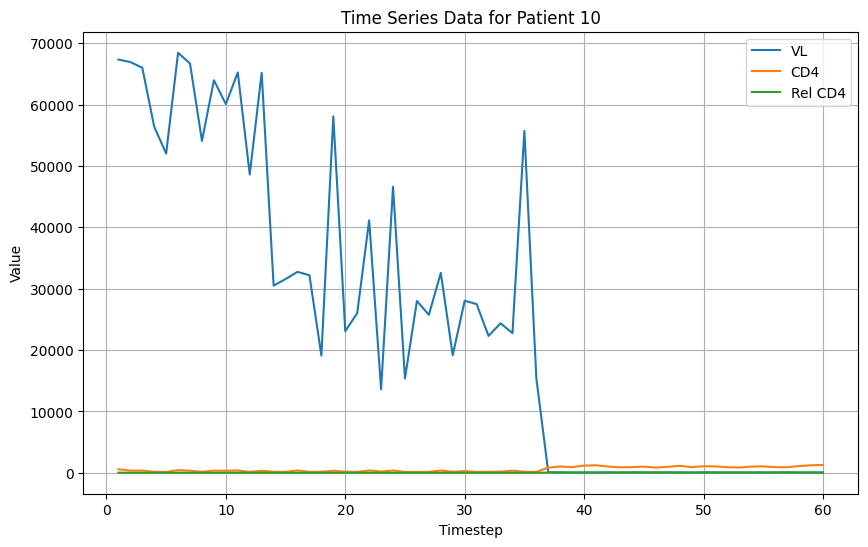

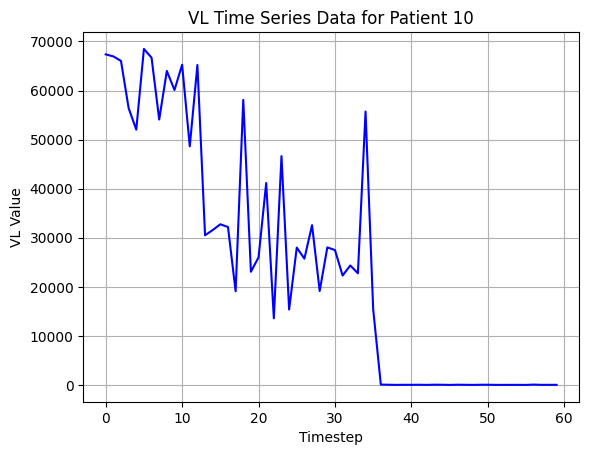

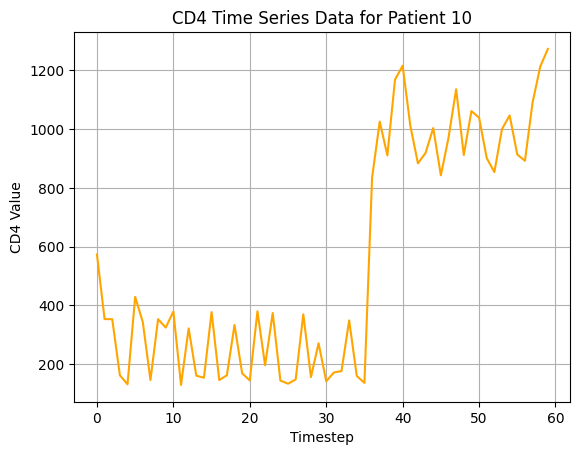

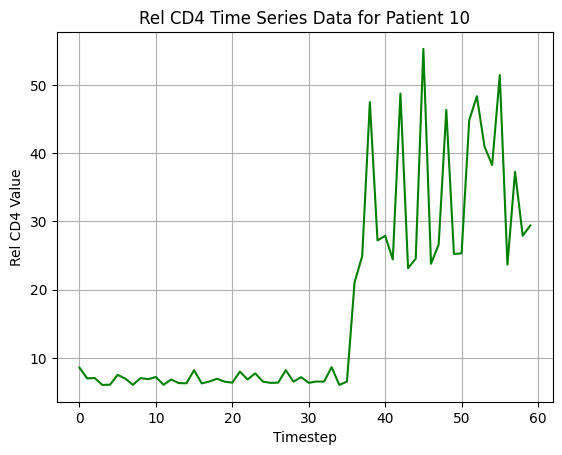

In [ ]:
# Plot time-series data for a specific patient
PATIENT_ID = 10
plot_time_series(data, patient_id=PATIENT_ID)
plot_vl(data, patient_id=PATIENT_ID)
plot_cd4(data, patient_id=PATIENT_ID)
plot_rel_cd4(data, patient_id=PATIENT_ID)

## Finding Correlation between VL and CD4

In [ ]:
# Initialize an empty list to store correlation coefficients
correlation_coefficients = []
start_PATIENT_ID = min(data['PatientID'])
end_PATIENT_ID = max(data['PatientID'])

# Iterate over each patient
for patient_id in range(start_PATIENT_ID, end_PATIENT_ID): 
    # Select data for the current patient
    patient_data = data[data['PatientID'] == patient_id]
    
    # Calculate correlation coefficient between "CD4" and "VL" for the current patient
    correlation = patient_data['CD4'].corr(patient_data['VL'])
    
    # Append correlation coefficient to the list
    correlation_coefficients.append(correlation)

# Calculate the average correlation coefficient across all patients
average_correlation = sum(correlation_coefficients) / len(correlation_coefficients)

# Plot scatter plot of correlation coefficients for each patient
plt.figure(figsize=(10, 6))
plt.scatter(range(start_PATIENT_ID, end_PATIENT_ID), correlation_coefficients, marker='.', color='b', alpha=0.5)
plt.xlabel('Patient ID')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients between CD4 and VL for Each Patient')
plt.grid(True)
plt.show()

# Plot histogram of correlation coefficients across all patients
plt.figure(figsize=(10, 6))
plt.hist(correlation_coefficients, bins=30, color='g', alpha=0.7)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Coefficients between CD4 and VL')
plt.grid(True)
plt.show()

print("Average correlation coefficient:", average_correlation)

In [ ]:
class MyEnvironment(gym.Env):
    def __init__(self, data, n_actions, n_features):
        super(MyEnvironment, self).__init__()
        # Define your environment here
        self.data = data
        self.state = self.reset()
        self.action_space = gym.spaces.Discrete(n_actions)
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(n_features,))

    def reset(self):
        # Reset environment to initial state
        self.state = self.data.iloc[0, :-1].values  # Initial state is the first row of preprocessed data (excluding the last column)
        return self.state

    def step(self, action):
        # Take action and return next state, reward, done flag, and optional info
        # For simplicity, let's assume the reward is based on the action and the next state
        # Here, we'll return a random reward and next state just for illustration purposes
        next_state = self.data.iloc[np.random.randint(len(self.data)), :-1].values  # Random next state
        reward = np.random.randn()  # Random reward
        done = False  # Episode termination flag (assume it's never done for this example)
        info = {}  # Additional info (optional)
        return next_state, reward, done, info


In [ ]:
# Step 4: Choose and implement RL algorithm (e.g., Q-learning, DQN, etc.)
# For simplicity, let's implement a basic Q-learning algorithm
class QLearningAgent:
    def __init__(self, n_actions, n_features, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.Q_table = np.zeros((n_features, n_actions))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)  # Random action with probability epsilon
        else:
            return np.argmax(self.Q_table[state, :])  # Greedy action with probability (1 - epsilon)

    def learn(self, state, action, reward, next_state):
        q_predict = self.Q_table[state, action]
        q_target = reward + self.gamma * np.max(self.Q_table[next_state, :])
        self.Q_table[state, action] += self.lr * (q_target - q_predict)


In [ ]:
# Step 5: Train RL model
n_actions = 2  # Number of actions
n_features = len(data.columns) - 1  # Number of features (excluding the target column)
agent = QLearningAgent(n_actions, n_features)

env = MyEnvironment(data, n_actions, n_features)
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

In [ ]:
# Step 6: Evaluate and validate RL model (optional)
# For simplicity, let's assume evaluation and validation are not performed in this example

# Step 7: Use RL model to predict new metrics (optional)
# Once the RL model is trained, it can be used to predict actions or outcomes based on new data instances
# For example, you can provide new feature vectors to the model and use its learned policy to predict actions
# Note: Make sure to preprocess new data instances in the same way as the training data

# Example of using the trained RL agent to predict actions for a new state
new_state = np.array([0.5, -0.2, 0.7])  # New state vector (preprocessed)
predicted_action = agent.choose_action(new_state)
print(f"Predicted Action for New State: {predicted_action}")


In [ ]:
import warnings
from collections import OrderedDict
from copy import deepcopy
from typing import Any, Callable, Dict, List, Optional, Sequence, Type

import gymnasium as gym
import numpy as np

from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvIndices, VecEnvObs, VecEnvStepReturn
from stable_baselines3.common.vec_env.patch_gym import _patch_env
from stable_baselines3.common.vec_env.util import copy_obs_dict, dict_to_obs, obs_space_info


[docs]class DummyVecEnv(VecEnv):
    """
    Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
    Python process. This is useful for computationally simple environment such as ``Cartpole-v1``,
    as the overhead of multiprocess or multithread outweighs the environment computation time.
    This can also be used for RL methods that
    require a vectorized environment, but that you want a single environments to train with.

    :param env_fns: a list of functions
        that return environments to vectorize
    :raises ValueError: If the same environment instance is passed as the output of two or more different env_fn.
    """

    actions: np.ndarray

    def __init__(self, env_fns: List[Callable[[], gym.Env]]):
        self.envs = [_patch_env(fn()) for fn in env_fns]
        if len(set([id(env.unwrapped) for env in self.envs])) != len(self.envs):
            raise ValueError(
                "You tried to create multiple environments, but the function to create them returned the same instance "
                "instead of creating different objects. "
                "You are probably using `make_vec_env(lambda: env)` or `DummyVecEnv([lambda: env] * n_envs)`. "
                "You should replace `lambda: env` by a `make_env` function that "
                "creates a new instance of the environment at every call "
                "(using `gym.make()` for instance). You can take a look at the documentation for an example. "
                "Please read https://github.com/DLR-RM/stable-baselines3/issues/1151 for more information."
            )
        env = self.envs[0]
        super().__init__(len(env_fns), env.observation_space, env.action_space)
        obs_space = env.observation_space
        self.keys, shapes, dtypes = obs_space_info(obs_space)

        self.buf_obs = OrderedDict([(k, np.zeros((self.num_envs, *tuple(shapes[k])), dtype=dtypes[k])) for k in self.keys])
        self.buf_dones = np.zeros((self.num_envs,), dtype=bool)
        self.buf_rews = np.zeros((self.num_envs,), dtype=np.float32)
        self.buf_infos: List[Dict[str, Any]] = [{} for _ in range(self.num_envs)]
        self.metadata = env.metadata

    def step_async(self, actions: np.ndarray) -> None:
        self.actions = actions

    def step_wait(self) -> VecEnvStepReturn:
        # Avoid circular imports
        for env_idx in range(self.num_envs):
            obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
                self.actions[env_idx]
            )
            # convert to SB3 VecEnv api
            self.buf_dones[env_idx] = terminated or truncated
            # See https://github.com/openai/gym/issues/3102
            # Gym 0.26 introduces a breaking change
            self.buf_infos[env_idx]["TimeLimit.truncated"] = truncated and not terminated

            if self.buf_dones[env_idx]:
                # save final observation where user can get it, then reset
                self.buf_infos[env_idx]["terminal_observation"] = obs
                obs, self.reset_infos[env_idx] = self.envs[env_idx].reset()
            self._save_obs(env_idx, obs)
        return (self._obs_from_buf(), np.copy(self.buf_rews), np.copy(self.buf_dones), deepcopy(self.buf_infos))

    def reset(self) -> VecEnvObs:
        for env_idx in range(self.num_envs):
            maybe_options = {"options": self._options[env_idx]} if self._options[env_idx] else {}
            obs, self.reset_infos[env_idx] = self.envs[env_idx].reset(seed=self._seeds[env_idx], **maybe_options)
            self._save_obs(env_idx, obs)
        # Seeds and options are only used once
        self._reset_seeds()
        self._reset_options()
        return self._obs_from_buf()

    def close(self) -> None:
        for env in self.envs:
            env.close()

    def get_images(self) -> Sequence[Optional[np.ndarray]]:
        if self.render_mode != "rgb_array":
            warnings.warn(
                f"The render mode is {self.render_mode}, but this method assumes it is `rgb_array` to obtain images."
            )
            return [None for _ in self.envs]
        return [env.render() for env in self.envs]  # type: ignore[misc]

    def render(self, mode: Optional[str] = None) -> Optional[np.ndarray]:
        """
        Gym environment rendering. If there are multiple environments then
        they are tiled together in one image via ``BaseVecEnv.render()``.

        :param mode: The rendering type.
        """
        return super().render(mode=mode)

    def _save_obs(self, env_idx: int, obs: VecEnvObs) -> None:
        for key in self.keys:
            if key is None:
                self.buf_obs[key][env_idx] = obs
            else:
                self.buf_obs[key][env_idx] = obs[key]  # type: ignore[call-overload]

    def _obs_from_buf(self) -> VecEnvObs:
        return dict_to_obs(self.observation_space, copy_obs_dict(self.buf_obs))

    def get_attr(self, attr_name: str, indices: VecEnvIndices = None) -> List[Any]:
        """Return attribute from vectorized environment (see base class)."""
        target_envs = self._get_target_envs(indices)
        return [getattr(env_i, attr_name) for env_i in target_envs]

    def set_attr(self, attr_name: str, value: Any, indices: VecEnvIndices = None) -> None:
        """Set attribute inside vectorized environments (see base class)."""
        target_envs = self._get_target_envs(indices)
        for env_i in target_envs:
            setattr(env_i, attr_name, value)

    def env_method(self, method_name: str, *method_args, indices: VecEnvIndices = None, **method_kwargs) -> List[Any]:
        """Call instance methods of vectorized environments."""
        target_envs = self._get_target_envs(indices)
        return [getattr(env_i, method_name)(*method_args, **method_kwargs) for env_i in target_envs]

    def env_is_wrapped(self, wrapper_class: Type[gym.Wrapper], indices: VecEnvIndices = None) -> List[bool]:
        """Check if worker environments are wrapped with a given wrapper"""
        target_envs = self._get_target_envs(indices)
        # Import here to avoid a circular import
        from stable_baselines3.common import env_util

        return [env_util.is_wrapped(env_i, wrapper_class) for env_i in target_envs]

    def _get_target_envs(self, indices: VecEnvIndices) -> List[gym.Env]:
        indices = self._get_indices(indices)
        return [self.envs[i] for i in indices]

IndentationError: unindent does not match any outer indentation level (<string>, line 105)

In [ ]:
import gym
from stable_baselines3 import DQN
from stable_baselines3.common.envs import DummyVecEnv
import pandas as pd

class CustomEnvironment(gym.Env):
    def __init__(self, data):
        super(CustomEnvironment, self).__init__()

        # Load data
        self.data = data
        self.current_step = 0
        self.max_steps = len(data) - 1

        # Define action and observation space
        self.action_space = gym.spaces.Discrete(10)  # Assuming 10 discrete dosage levels
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(5,), dtype=float)  # Assuming values are in the range [0, 100]

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values

    def step(self, action):
        # Execute action and get the next state, reward, and done status
        self.current_step += 1
        next_state = self.data.iloc[self.current_step].values
        reward = -abs(self.data.iloc[self.current_step]['Dosage'] - action)  # Negative reward based on the difference
        done = self.current_step == self.max_steps - 1
        return next_state, reward, done, {}

# Load data
data = pd.read_csv('HIV_dataset.csv')
data_trim = data[['VL', 'CD4']]
# Create the Gym Environment
env = CustomEnvironment(data)
env = DummyVecEnv([lambda: env])  # Wrap the environment to make it compatible with Stable Baselines 3

# Choose an Algorithm and Configure the Model
model = DQN("MlpPolicy", env, verbose=1)

# Train the Model
model.learn(total_timesteps=10000)

# Test and Evaluate
obs = env.reset()
for _ in range(1000):  # Test for 1000 steps
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    if done:
        obs = env.reset()

ImportError: cannot import name 'DummyVecEnv' from 'stable_baselines3.common.envs' (/Users/work/miniconda3/envs/mlda/lib/python3.12/site-packages/stable_baselines3/common/envs/__init__.py)